# Helper Functions

In [ ]:
import os

folder1 = '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister'
folder2 = '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Anthracnose'

jpgs1 = {f for f in os.listdir(folder1) if f.lower().endswith('.jpg')}
jpgs2 = {f for f in os.listdir(folder2) if f.lower().endswith('.jpg')}

common_jpgs = jpgs1.intersection(jpgs2)

print(f"Number of common jpg files: {len(common_jpgs)}")
print("Common jpg files:", common_jpgs)


Number of common jpg files: 193
Common jpg files: {'S E6 07.10.2023 IMG20231007113645.jpg', 'D E6 06.10.2023 DSC_3265.JPG', 'D E6 06.10.2023 DSC_3224.JPG', 'D E6 06.10.2023 DSC_3195.JPG', 'S E6 07.10.2023 IMG20231007114350.jpg', 'D E6 06.10.2023 DSC_3222.JPG', 'S E6 07.10.2023 IMG20231007113243.jpg', 'S E6 07.10.2023 IMG20231007113001.jpg', 'S E6 07.10.2023 IMG20231007113345.jpg', 'S E6 07.10.2023 IMG20231007114008.jpg', 'S E6 07.10.2023 IMG20231007113445.jpg', 'S E6 06.10.2023 IMG_20231006_170931~2.jpg', 'D E6 06.10.2023 DSC_3217.JPG', 'S E6 06.10.2023 IMG_20231006_170931.jpg', 'D E6 06.10.2023 DSC_3240.JPG', 'S E6 07.10.2023 IMG20231007113425.jpg', 'S E6 06.10.2023 IMG_20231006_163250.jpg', 'D E6 06.10.2023 DSC_3238.JPG', 'D E6 06.10.2023 DSC_3251.JPG', 'D E6 06.10.2023 DSC_3242.JPG', 'S E6 07.10.2023 IMG20231007114502.jpg', 'S E6 06.10.2023 IMG_20231006_162659.jpg', 'D E6 06.10.2023 DSC_3233.JPG', 'S E6 06.10.2023 IMG_20231006_163321~2.jpg', 'D E6 06.10.2023 DSC_3228.JPG', 'S E6 07.

In [ ]:
import os
root_path = '/raid/ee-mariyam/maryam/abhijeet/Raw_Dataset/New_Dataset_220424'
def get_jpg_paths(base_dir):
    jpg_dict = {}
    
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        if os.path.isdir(folder_path):
            jpg_paths = []
            
            for file_name in os.listdir(folder_path):
                if file_name.lower().endswith('.jpg'):
                    file_path = os.path.join(folder_path, file_name)
                    jpg_paths.append(file_path)
            
            if jpg_paths:
                jpg_dict[folder_name] = jpg_paths
    
    return jpg_dict

combined_files_path = root_path
jpg_paths_dict = get_jpg_paths(combined_files_path)


In [2]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F 
import cv2
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def evaluate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return all_labels, all_preds



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, num_classes, class_names, normalize=True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', cbar=False, 
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix' if normalize else 'Confusion Matrix')
    plt.show()


In [ ]:
def plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='green')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_classwise_accuracy(cm, jpg_paths_dict):
    total_accuracy = np.trace(cm) / np.sum(cm)

    classwise_accuracy = cm.diagonal() / cm.sum(axis=1)

    class_names = list(jpg_paths_dict.keys())  
    classwise_accuracy = [
        acc if cm.sum(axis=1)[i] > 0 else np.nan
        for i, acc in enumerate(classwise_accuracy)
    ]

    print(f"Total Accuracy: {total_accuracy * 100:.2f}%")
    for i, accuracy in enumerate(classwise_accuracy):
        if np.isnan(accuracy):
            print(f"Class '{class_names[i]}' Accuracy: N/A (no samples)")
        else:
            print(f"Class '{class_names[i]}' Accuracy: {accuracy * 100:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, classwise_accuracy, color='skyblue')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.ylim(0, 1)  
    plt.axhline(total_accuracy, color='red', linestyle='--', label='Total Accuracy')
    plt.xticks(rotation=45)  
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()  
    plt.show()

In [9]:
jpg_paths_comb_dict = jpg_paths_dict.copy()


In [10]:
for subfolder, jpg_files in jpg_paths_comb_dict.items():
    print(f"Subfolder: {subfolder}")
    print(f"Number of JPEG files: {len(jpg_files)}")
    print()

Subfolder: Twister
Number of JPEG files: 278

Subfolder: Healthy
Number of JPEG files: 600

Subfolder: Stemphylium
Number of JPEG files: 400

Subfolder: Anthracnose
Number of JPEG files: 204

Subfolder: Purple Blotch
Number of JPEG files: 209



## New

In [ ]:

from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, jpg_files_dict, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}
        self._prepare_data(jpg_files_dict)

        self.default_transform = transforms.Compose([
            transforms.ToTensor(),  
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        ])

    def _prepare_data(self, jpg_files_dict):
        for label_idx, (subfolder, file_paths) in enumerate(jpg_files_dict.items()):
            self.label_map[subfolder] = label_idx
            for file_path in file_paths:
                self.image_paths.append(file_path)
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, IOError) as e:
            print(f'Error loading image {img_path}: {e}')
            image = Image.new('RGB', (224, 224))  
            label = self.labels[idx]
        else:
            label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = self.default_transform(image)

        return image, label


In [ ]:
from PIL import Image
import numpy as np
import cv2

class BalancedDataset(CustomImageDataset):
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if image is None or image.size == 0:
                raise ValueError("Invalid image")
        except Exception:
            image = np.zeros((224, 224, 3), dtype=np.uint8)  

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
        else:
            image = self.default_transform(image)

        return image, label


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class DenseNet121WithCBAMandMLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base = models.densenet121(pretrained=True)
        self.features = self.base.features
        
        self.cbam1 = CBAM(1024)
        self.cbam2 = CBAM(1024)
        
        self.mlp = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        features = self.features(x)                 
        features = self.cbam1(features)
        features = F.relu(features)
        features = self.cbam2(features)
        
        out = F.adaptive_avg_pool2d(features, (1, 1)) 
        out = torch.flatten(out, 1)                   
        return self.mlp(out)                         


In [ ]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super().__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels//reduction_ratio, 1),
            nn.ReLU(),
            nn.Conv2d(channels//reduction_ratio, channels, 1),
            nn.Sigmoid()
        )
        
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(channels, 1, 7, padding=3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        channel = self.channel_attention(x)
        x = x * channel
        spatial = self.spatial_attention(x)
        return x * spatial


In [18]:
import numpy as np
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedKFold

dataset = BalancedDataset(jpg_files_dict=jpg_paths_comb_dict, transform=transform)

labels = np.array(dataset.labels)

num_total = len(dataset)
num_train_val = int(0.8 * num_total)
num_test = num_total - num_train_val
indices = np.arange(num_total)
np.random.seed(42)
np.random.shuffle(indices)

train_val_indices = indices[:num_train_val]
test_indices = indices[num_train_val:]

train_val_labels = labels[train_val_indices]
test_labels = labels[test_indices]
train_val_dataset = Subset(dataset, train_val_indices)
test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=64)


In [19]:

import numpy as np
import torch
class_counts = []
for subfolder, jpg_files in jpg_paths_comb_dict.items():
    class_counts.append(len(jpg_files))
def compute_class_weights(label_map, dataset):
    print(class_counts)
    class_weights = np.max(class_counts) / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(class_weights)
    return class_weights

class_weights = compute_class_weights(dataset.label_map, dataset)
criterion = nn.CrossEntropyLoss(weight=class_weights)


[278, 600, 400, 204, 209]


tensor([2.1583, 1.0000, 1.5000, 2.9412, 2.8708], device='cuda:0')


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5, fold=None, save_dir='./Models', final=False):
    best_acc = 0.0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects / total

        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_corrects += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs} '
              f'Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_acc:.4f} '
              f'Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}')

        if not final and val_acc > best_acc:
            best_acc = val_acc
            save_path = f'{save_dir}/model_fold_{fold}_compare_only_cbam.pth'
            torch.save(model.state_dict(), save_path)
            print(f'Saved best model for fold {fold} with accuracy: {best_acc:.4f}')

    if final:
        save_path = f'{save_dir}/final_model_compare_only_cbam.pth'
        torch.save(model.state_dict(), save_path)
        print(f'Final model saved to {save_path}')
    else:
        print(f'Best Validation Accuracy for fold {fold}: {best_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, (best_acc if not final else None)


In [22]:
num_classes = len(jpg_paths_comb_dict.keys())
print(num_classes)

5


In [ ]:
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
class_names = list(jpg_paths_comb_dict.keys())

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
fold_best_accuracies = []

all_true_labels_cv = []
all_pred_labels_cv = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_indices, train_val_labels)):
    print(f"\n--- Fold {fold + 1} ---")

    fold_train_dataset = Subset(train_val_dataset, train_idx)
    fold_val_dataset = Subset(train_val_dataset, val_idx)

    train_loader = DataLoader(fold_train_dataset, batch_size=32, shuffle=True, num_workers=64)
    val_loader = DataLoader(fold_val_dataset, batch_size=32, shuffle=False, num_workers=64)

    model = DenseNet121WithCBAMandMLP(num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses, train_accs, val_accs, best_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, device,
        num_epochs=20, fold=fold, save_dir='./Models/CV/', final=False
    )

    fold_train_losses.append(train_losses[-1])
    fold_val_losses.append(val_losses[-1])
    fold_train_accuracies.append(train_accs[-1])
    fold_val_accuracies.append(val_accs[-1])
    fold_best_accuracies.append(best_acc)

    model.eval()
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(preds.cpu().numpy())

    all_true_labels_cv.extend(val_true_labels)
    all_pred_labels_cv.extend(val_pred_labels)

print("\n=== Cross Validation Metrics ===")
print(f"Overall CV Accuracy: {accuracy_score(all_true_labels_cv, all_pred_labels_cv):.4f}")
print(classification_report(all_true_labels_cv, all_pred_labels_cv, target_names=class_names))



--- Fold 1 ---
Epoch 1/20 Train Loss: 1.5105 Train Accuracy: 0.3848 Val Loss: 1.3170 Val Accuracy: 0.5498
Saved best model for fold 0 with accuracy: 0.5498
Epoch 2/20 Train Loss: 1.1778 Train Accuracy: 0.6466 Val Loss: 0.9659 Val Accuracy: 0.7122
Saved best model for fold 0 with accuracy: 0.7122
Epoch 3/20 Train Loss: 0.7128 Train Accuracy: 0.8076 Val Loss: 0.6010 Val Accuracy: 0.8376
Saved best model for fold 0 with accuracy: 0.8376
Epoch 4/20 Train Loss: 0.3756 Train Accuracy: 0.9167 Val Loss: 0.7206 Val Accuracy: 0.8376
Epoch 5/20 Train Loss: 0.1502 Train Accuracy: 0.9685 Val Loss: 0.5910 Val Accuracy: 0.8635
Saved best model for fold 0 with accuracy: 0.8635
Epoch 6/20 Train Loss: 0.0912 Train Accuracy: 0.9796 Val Loss: 0.6489 Val Accuracy: 0.8782
Saved best model for fold 0 with accuracy: 0.8782
Epoch 7/20 Train Loss: 0.0955 Train Accuracy: 0.9750 Val Loss: 0.7074 Val Accuracy: 0.8893
Saved best model for fold 0 with accuracy: 0.8893
Epoch 8/20 Train Loss: 0.0756 Train Accuracy: 0

In [24]:
import numpy as np

print("\n=== 5-Fold Cross Validation Summary ===")
print(f"Average Train Accuracy: {np.mean(fold_train_accuracies):.4f} ± {np.std(fold_train_accuracies):.4f}")
print(f"Average Val Accuracy:   {np.mean(fold_val_accuracies):.4f} ± {np.std(fold_val_accuracies):.4f}")
print(f"Average Train Loss:     {np.mean(fold_train_losses):.4f} ± {np.std(fold_train_losses):.4f}")
print(f"Average Val Loss:       {np.mean(fold_val_losses):.4f} ± {np.std(fold_val_losses):.4f}")



=== 5-Fold Cross Validation Summary ===
Average Train Accuracy: 0.9928 ± 0.0041
Average Val Accuracy:   0.8839 ± 0.0067
Average Train Loss:     0.0228 ± 0.0153
Average Val Loss:       0.8688 ± 0.2066


In [ ]:
import torch
import time
import copy
import os

def train_model_v2(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5, fold=None, save_dir='./Models', final=False):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 30)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_corrects = 0
            val_total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)
                    val_total += labels.size(0)

            epoch_val_loss = val_loss / val_total
            epoch_val_acc = val_corrects.double() / val_total
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_acc.item())

            print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

            if not final and epoch_val_acc > best_acc:
                best_acc = epoch_val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, f'model_fold_cbam_{fold}_only_compare.pth')
                torch.save(best_model_wts, save_path)
                print(f'--> Best model saved for fold {fold} with acc {best_acc:.4f}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    if final:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, 'final_model_cbam_only_compare.pth')
        torch.save(model.state_dict(), save_path)
        print(f'Final model saved to {save_path}')
    elif best_acc > 0.0:
        model.load_state_dict(best_model_wts)
        print(f'Loaded best model weights with acc: {best_acc:.4f}')
        return train_losses, val_losses, train_accuracies, val_accuracies, best_acc
    else:
        print(f'No validation provided. Final training metrics only.')

    return train_losses, val_losses, train_accuracies, val_accuracies

Epoch 1/20
------------------------------
Train Loss: 1.4206 Acc: 0.3691

Epoch 2/20
------------------------------


Train Loss: 0.8313 Acc: 0.7567

Epoch 3/20
------------------------------
Train Loss: 0.3873 Acc: 0.8883

Epoch 4/20
------------------------------
Train Loss: 0.2671 Acc: 0.9172

Epoch 5/20
------------------------------
Train Loss: 0.1293 Acc: 0.9704

Epoch 6/20
------------------------------
Train Loss: 0.0961 Acc: 0.9756

Epoch 7/20
------------------------------
Train Loss: 0.0938 Acc: 0.9712

Epoch 8/20
------------------------------
Train Loss: 0.0450 Acc: 0.9896

Epoch 9/20
------------------------------
Train Loss: 0.0234 Acc: 0.9933

Epoch 10/20
------------------------------
Train Loss: 0.0335 Acc: 0.9926

Epoch 11/20
------------------------------
Train Loss: 0.0673 Acc: 0.9778

Epoch 12/20
------------------------------
Train Loss: 0.0633 Acc: 0.9815

Epoch 13/20
------------------------------
Train Loss: 0.0534 Acc: 0.9859

Epoch 14/20
------------------------------
Train Loss: 0.0281 Acc: 0.9926

Epoch 15/20
------------------------------
Train Loss: 0.0288 Acc: 0.9896



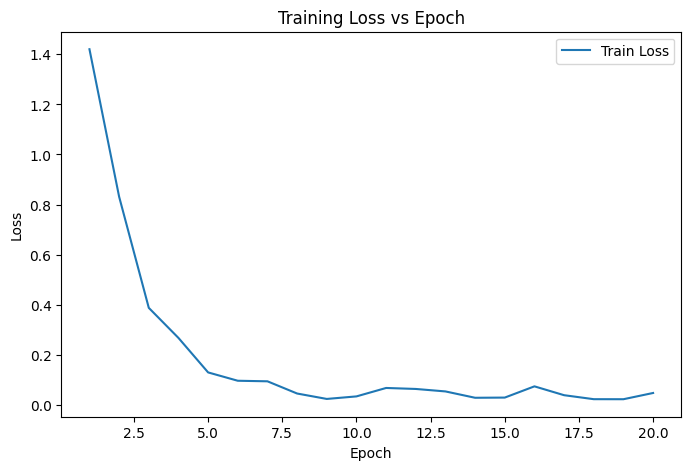

In [ ]:
import matplotlib.pyplot as plt
import os

full_train_loader = DataLoader(train_val_dataset, batch_size=32, shuffle=True, num_workers=64)

final_model = DenseNet121WithCBAMandMLP(num_classes=num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-4)

train_losses, val_losses, train_accs, val_accs = train_model_v2(
    model=final_model,
    train_loader=full_train_loader,
    val_loader=None,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20,
    final=True,
    save_dir='./Models'
)


os.makedirs('./Models', exist_ok=True)
torch.save(final_model.state_dict(), './Models/final_model_only_cbam_only_compare.pth')
print("Saved final model to ./Models/final_model_only_compare.pth")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()


In [27]:
final_model.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())


Test Accuracy: 0.9174

Classification Report:
               precision    recall  f1-score   support

      Twister       0.98      0.96      0.97        52
      Healthy       1.00      1.00      1.00       111
  Stemphylium       0.88      0.88      0.88        78
  Anthracnose       0.84      0.91      0.87        45
Purple Blotch       0.80      0.75      0.78        53

     accuracy                           0.92       339
    macro avg       0.90      0.90      0.90       339
 weighted avg       0.92      0.92      0.92       339



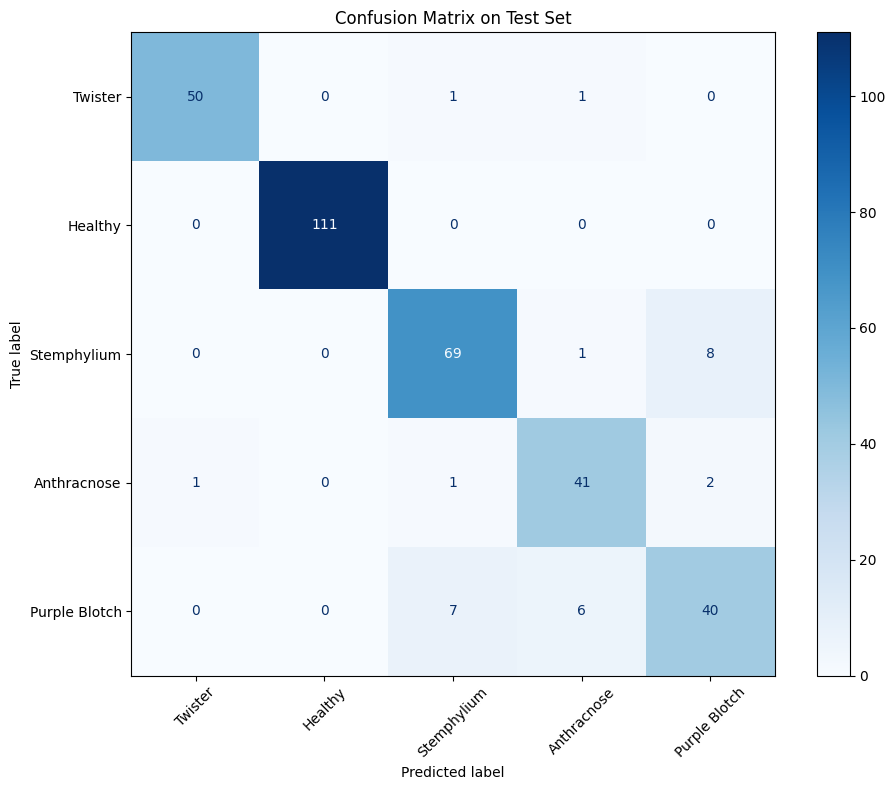

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

acc = accuracy_score(all_true, all_pred)
print(f"Test Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(all_true, all_pred, target_names=dataset.label_map.keys()))

cm = confusion_matrix(all_true, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(dataset.label_map.keys()))

fig, ax = plt.subplots(figsize=(10,8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()
